In [ ]:
!pip install darts

In [ ]:
!pip install statsmodels

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import TimeSeriesSplit
import gdown
import os
import warnings
import io
import requests

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

Next working steps from: https://colab.research.google.com/drive/1DME-DdKQy73Ol1pIh4Br8R8Avh8p_ZvA?usp=sharing

In [ ]:
# Load the CSV file into a DataFrame
df_merged_uno = pd.read_csv('df_merged_uno.csv')

# Verify the DataFrame has been loaded correctly
display(df_merged_uno.head())

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family,class,perishable,...,year,month,day,day_of_week,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,302230,2013-01-09,24,96995,2.0,True,0.215699,GROCERY I,1093,False,...,2013,1,9,2,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,93.08
1,3580799,2013-03-29,24,96995,1.0,True,-0.718997,GROCERY I,1093,False,...,2013,3,29,4,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,93.08
2,2059376,2013-02-21,24,96995,1.0,True,-0.718997,GROCERY I,1093,False,...,2013,2,21,3,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,92.79
3,3800436,2013-04-03,24,96995,2.0,True,0.215699,GROCERY I,1093,False,...,2013,4,3,2,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,95.02
4,4781432,2013-04-26,24,96995,2.0,True,0.215699,GROCERY I,1093,False,...,2013,4,26,4,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,92.63


In [ ]:
df_merged_uno.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico'],
      dtype='object')

Original Sales Data: id, date, store_nbr, item_nbr, unit_sales, onpromotion.

Item Features: family, class, and perishable.

Store Features: city, state, store_type and cluster.

Date-based Features: year, month, day, and day_of_week.

Holiday Information: holiday_type, locale, locale_name, description, and transferred.

Oil Prices: dcoilwtico.

In [ ]:
df_merged_uno.shape

(1311540, 24)

In [ ]:
# Load the CSV file into a DataFrame
df_transactions = pd.read_csv('transactions.csv')

# Verify the DataFrame has been loaded correctly
display(df_transactions.head())

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
# Create the dfs dictionary and load only the transactions file
dfs = {}
dfs['transactions'] = pd.read_csv('transactions.csv')

# Convert the 'date' columns to datetime in both DataFrames
df_merged_uno['date'] = pd.to_datetime(df_merged_uno['date'])
dfs['transactions']['date'] = pd.to_datetime(dfs['transactions']['date'])

# Merge with transactions
df_merged_deux = pd.merge(df_merged_uno, dfs['transactions'], on=['date', 'store_nbr'], how='left')

print("Fifth Merge complete.")

print("--- HEAD of merged dataframe ---")
display(df_merged_deux.head())
print("\n--- TAIL of merged dataframe ---")
display(df_merged_deux.tail())


Fifth Merge complete.
--- HEAD of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family,class,perishable,...,month,day,day_of_week,holiday_type,locale,locale_name,description,transferred,dcoilwtico,transactions
0,302230,2013-01-09,24,96995,2.0,True,0.215699,GROCERY I,1093,False,...,1,9,2,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,93.08,2354.0
1,3580799,2013-03-29,24,96995,1.0,True,-0.718997,GROCERY I,1093,False,...,3,29,4,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,93.08,1803.0
2,2059376,2013-02-21,24,96995,1.0,True,-0.718997,GROCERY I,1093,False,...,2,21,3,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,92.79,2362.0
3,3800436,2013-04-03,24,96995,2.0,True,0.215699,GROCERY I,1093,False,...,4,3,2,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,95.02,2719.0
4,4781432,2013-04-26,24,96995,2.0,True,0.215699,GROCERY I,1093,False,...,4,26,4,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,92.63,2530.0



--- TAIL of merged dataframe ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family,class,perishable,...,month,day,day_of_week,holiday_type,locale,locale_name,description,transferred,dcoilwtico,transactions
1311535,122354275,2017-07-16,51,2116416,2.0,False,-0.707107,GROCERY I,1060,False,...,7,16,6,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,49.37,1903.0
1311536,122762341,2017-07-20,51,2116416,4.0,False,0.707107,GROCERY I,1060,False,...,7,20,3,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,46.73,1515.0
1311537,125388723,2017-08-14,51,2122188,2.0,False,0.577350,GROCERY I,1084,False,...,8,14,0,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,47.59,1446.0
1311538,124770634,2017-08-08,51,2122188,1.0,False,-1.154701,GROCERY I,1084,False,...,8,8,1,Non-Holiday,No Holiday,No Holiday,No Holiday,No Holiday,49.07,1469.0
1311539,124970207,2017-08-10,51,2122188,2.0,False,0.577350,GROCERY I,1084,False,...,8,10,3,Holiday,National,Ecuador,Primer Grito de Independencia,True,48.54,1452.0


In [ ]:
df_merged_deux.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'transactions'],
      dtype='object')

Sales and Time Data: unit_sales, date, onpromotion, and z_score.

Store Information: store_nbr, city, state, store_type, and cluster.

Item Information: item_nbr, family_x, class, and perishable.

External Features: holiday_type, dcoilwtico (oil prices), and the newly added transactions.

In [ ]:
df_merged_deux.isna().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
z_score,0
family,0
class,0
perishable,0


In [ ]:
# Focus on transactions, use ffill
df_merged_deux['transactions'] = df_merged_deux['transactions'].ffill().bfill()

# Final check for remaining missing values
print("\nFinal check for missing values:")
print(df_merged_deux.isna().sum())


Final check for missing values:
id              0
date            0
store_nbr       0
item_nbr        0
unit_sales      0
onpromotion     0
z_score         0
family          0
class           0
perishable      0
city            0
state           0
store_type      0
cluster         0
year            0
month           0
day             0
day_of_week     0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
transactions    0
dtype: int64


In [ ]:
series = TimeSeries.from_dataframe(df_merged_deux, value_cols='unit_sales')

Visualizing data Part 1

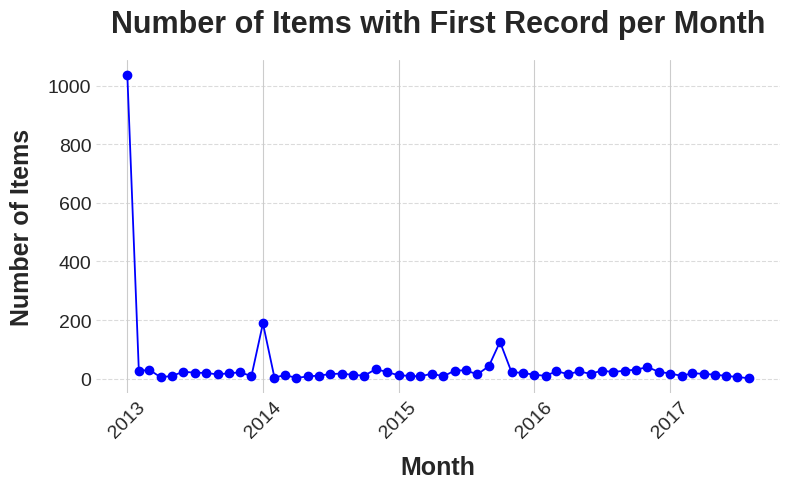

In [ ]:
# Identify the first record for each item by date
df_merged_deux['date'] = pd.to_datetime(df_merged_deux['date'])  # Ensure the date column is in datetime format
first_record_per_item = df_merged_deux.groupby('item_nbr')['date'].min().reset_index()

# Extract year and month and count items for each month
first_record_per_item['YearMonth'] = first_record_per_item['date'].dt.to_period('M')
items_per_month = first_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
items_per_month['YearMonth'] = items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(items_per_month['YearMonth'], items_per_month['Item Count'], marker='o', linestyle='-', color='b')  # Line plot with markers

# Add titles and labels
plt.title('Number of Items with First Record per Month', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


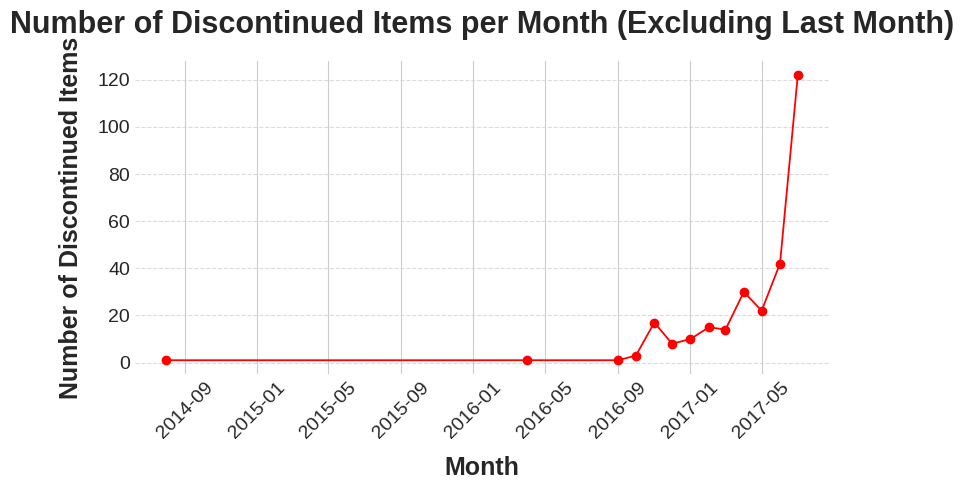

In [ ]:
# Identify the last record for each item by date
df_merged_deux['date'] = pd.to_datetime(df_merged_deux['date'])  # Ensure the date column is in datetime format
last_record_per_item = df_merged_deux.groupby('item_nbr')['date'].max().reset_index()

# Extract year and month for each item's last record
last_record_per_item['YearMonth'] = last_record_per_item['date'].dt.to_period('M')

# Exclude the last month in the dataset
last_month = last_record_per_item['YearMonth'].max()
filtered_last_record_per_item = last_record_per_item[last_record_per_item['YearMonth'] != last_month]

# Count items discontinued per month (excluding the last month)
discontinued_items_per_month = filtered_last_record_per_item['YearMonth'].value_counts().sort_index().reset_index()
discontinued_items_per_month.columns = ['YearMonth', 'Item Count']

# Convert YearMonth back to datetime for plotting
discontinued_items_per_month['YearMonth'] = discontinued_items_per_month['YearMonth'].dt.to_timestamp()

# Plot the data
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(discontinued_items_per_month['YearMonth'], discontinued_items_per_month['Item Count'], marker='o', linestyle='-', color='r')  # Line plot with markers

# Add titles and labels
plt.title('Number of Discontinued Items per Month (Excluding Last Month)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=18, labelpad=10)
plt.ylabel('Number of Discontinued Items', fontsize=18, labelpad=10)

# Format the x-axis labels
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


Autocorrelation and Stationarity

Stationarity

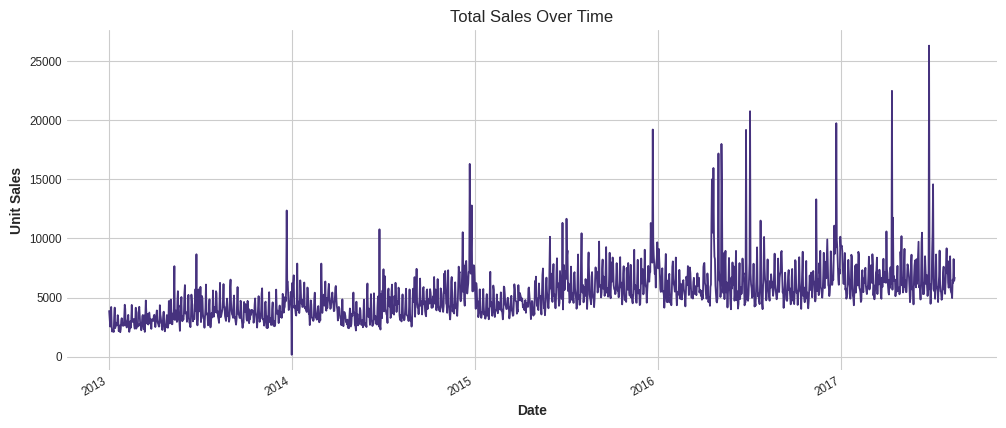

In [ ]:
# Visual check
# Ensure 'date' is a datetime object and sort
df_merged_deux['date'] = pd.to_datetime(df_merged_deux['date'])
df_merged_deux.sort_values('date', inplace=True)

# Group the data by date and sum the unit sales
sales_by_date = df_merged_deux.groupby('date')['unit_sales'].sum()

# Plot the aggregated series
plt.figure(figsize=(12, 5))
sales_by_date.plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

In [ ]:
def test_stationarity(timeseries, title):
    """
    Performs the Augmented Dickey-Fuller test and prints the results.
    """
    print(f"\n--- Stationarity Test: {title} ---")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Result: The time series is likely stationary (p-value <= 0.05).")
    else:
        print("Result: The time series is likely non-stationary (p-value > 0.05).")
    print("-" * (len(title) + 25))
    return dftest[1] <= 0.05

# Used function on sales data
# Aggregated data by date to get a single time series
sales_by_date = df_merged_deux.groupby('date')['unit_sales'].sum().dropna()

# Run the test
is_stationary = test_stationarity(sales_by_date, "Total Daily Unit Sales")


--- Stationarity Test: Total Daily Unit Sales ---
Test Statistic                   -3.381728
p-value                           0.011598
#Lags Used                       22.000000
Number of Observations Used    1657.000000
Critical Value (1%)              -3.434303
Critical Value (5%)              -2.863286
Critical Value (10%)             -2.567699
dtype: float64
Result: The time series is likely stationary (p-value <= 0.05).
-----------------------------------------------


P-value: A low p-value (≤ 0.05) indicates that the data does not have a unit root, meaning it is stationary. The p-value of 0.011598 is well below this threshold.

Test Statistic: The test statistic (-3.381728) is more negative than the critical value at the 5% level (-2.863286). This also supports the conclusion that the series is stationary.

These results show that the statistical properties of the time series (like mean and variance) are stable over time. This is a crucial assumption for many forecasting models, giving the go ahead to proceed with models like ARIMA without needing to apply differencing to make the data stationary.

Autocorrelation

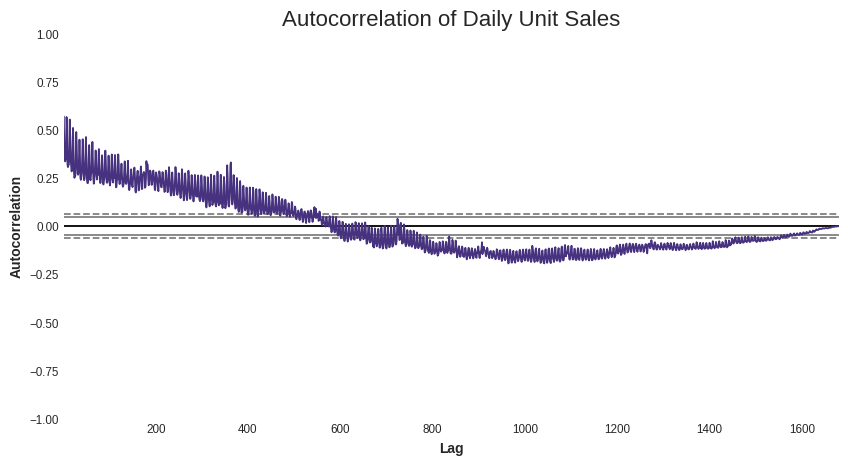

In [ ]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_merged_deux.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()

High Correlation at Early Lags: The plot starts with a high positive correlation that gradually decreases, which is typical for a time series with a trend or daily-level patterns.

Recurring Spikes: The most important feature is the recurring pattern of peaks every 7 lags. This indicates a strong weekly seasonality. Sales are highly correlated with sales from the same day of the week (e.g., Tuesday's sales are highly correlated with sales from the previous Tuesday).

There is a predictable, repeating weekly pattern. This is why a Seasonal ARIMA (SARIMA) model, which can account for both non-seasonal and seasonal components, is a better choice for this data than a simple ARIMA model.

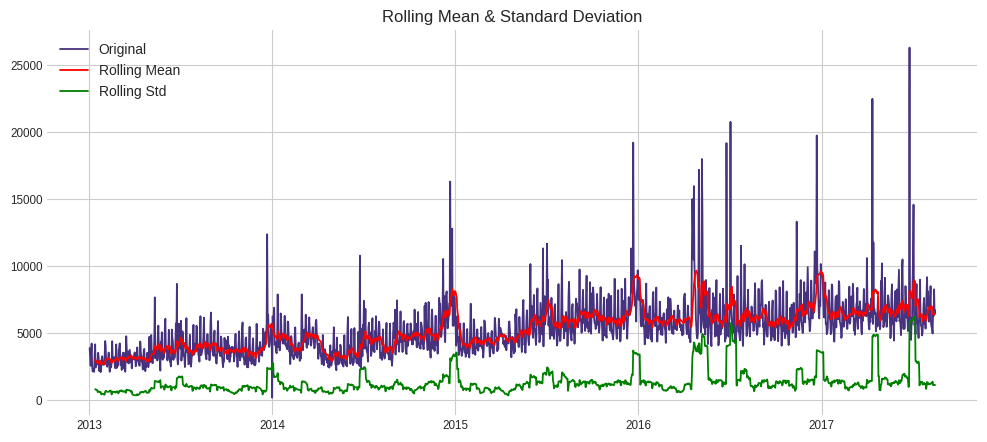

In [ ]:
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [ ]:
# Statistical test: Augmented Dickey-Fuller (ADF)

from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_by_date)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -3.381727610399682
p-value: 0.011597773291354365


ADF Statistic: The test statistic is −3.38. This value is more negative than the critical value at the 5% level further supporting the conclusion of stationarity.

STL Decomposition

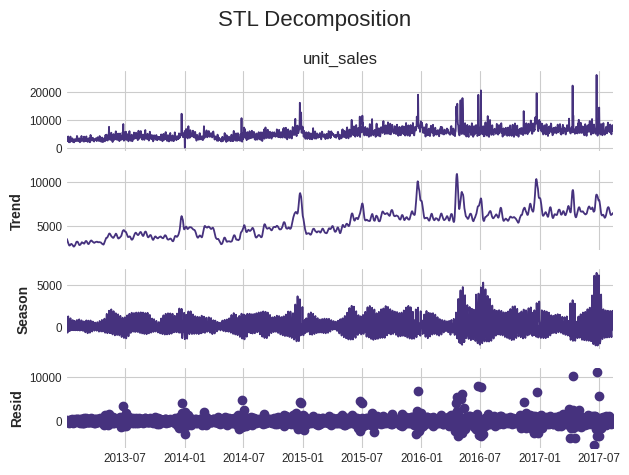

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# STL decomposition
sales_by_date = df_merged_deux.groupby('date')['unit_sales'].sum()
stl = STL(sales_by_date, period=7)
res = stl.fit()

# Plot STL decomposition
fig = res.plot()
fig.suptitle("STL Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

Measure Strength of Trend and Seasonality

In [ ]:
# Calculate strength of trend and seasonality
# Based on Hyndman’s definition: Strength = 1 - (variance of remainder / variance of (component + remainder))

import numpy as np

trend_strength = 1 - (np.var(res.resid) / np.var(res.trend + res.resid))
seasonal_strength = 1 - (np.var(res.resid) / np.var(res.seasonal + res.resid))

print(f"Strength of Trend: {trend_strength:.2f}")
print(f"Strength of Seasonality: {seasonal_strength:.2f}")

Strength of Trend: 0.73
Strength of Seasonality: 0.58


How to Interpret Strength Values:

Close to 1.00 → very strong trend/seasonality

Close to 0.00 → weak or no trend/seasonality

This helps decide if there is a need to:

Remove trend (e.g., differencing)

Remove seasonality (e.g., seasonal differencing or modeling with SARIMA)

Trend Component
The Trend plot shows a clear upward trajectory over the years. This means that overall, sales have been increasing over time. This is a long-term, underlying movement in the data.

Seasonality Component
The Season plot shows a repeating, cyclical pattern, which is very common in sales data. It indicates that sales are influenced by recurring events, such as a weekly cycle or holidays. The peaks and troughs in this plot suggest higher sales at predictable times of the year.

Residual Component
The Resid (Residuals) plot shows what's left of the time series after the trend and seasonality have been removed. These are random, unpredictable fluctuations. The large spikes in this plot represent anomalies or outliers, which are significant, short-term sales events that don't fit the overall trend or seasonal pattern. These could be due to promotions, special events, or data errors.

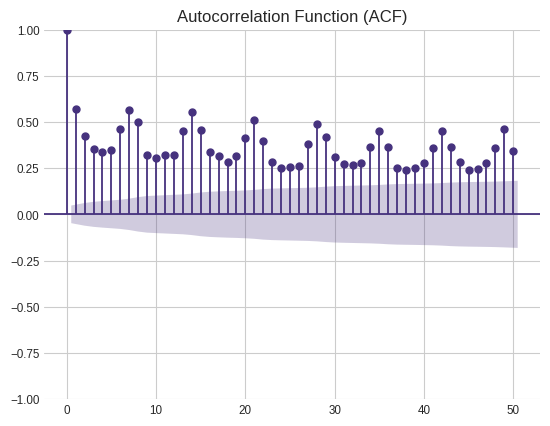

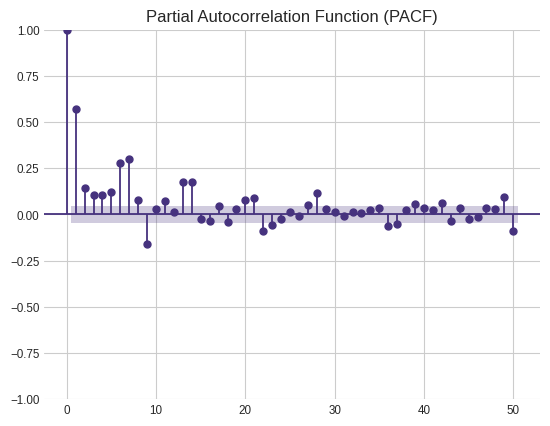

In [ ]:
# Plot the Autocorrelation Function (ACF)
# Lags = number of time points back to consider

# Aggregate the data to a daily level
sales_by_date = df_merged_deux.groupby('date')['unit_sales'].sum()
plot_acf(sales_by_date, lags=50, title='Autocorrelation Function (ACF)')
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(sales_by_date, lags=50, title='Partial Autocorrelation Function (PACF)')
plt.show()

There's a strong weekly seasonality in the data. The plot shows a repeating pattern of high correlations at lags that are multiples of 7 (7, 14, 21, 28, etc.). This indicates that the sales are highly correlated with sales from the same day of the week in prior weeks.

Lag 0: The ACF is always 1 at lag 0, as the time series is perfectly correlated with itself.

Gradual Decline: The correlations generally decline as the lag increases, which is a common characteristic of time series data.

Spikes at Multiples of 7: The most prominent feature is the series of spikes that occur every 7 lags. Each of these spikes is significantly above the blue shaded confidence region, confirming that the correlation is statistically significant. This confirms a strong weekly seasonality.

Conclusion: A Seasonal ARIMA (SARIMA) model should be used to capture both the non-seasonal and seasonal components of the data.

# **Feature Engineering**

In [ ]:
# Ensure df_merged_deux has a clean 'date' column
df_merged_deux['date'] = pd.to_datetime(df_merged_deux['date'])

def process_holidays(df_holidays):
    """Processes the holiday events data to create relevant features."""
    df_holidays['date'] = pd.to_datetime(df_holidays['date'])

    # Aggregate and create new boolean columns
    holidays_agg = df_holidays.groupby('date').agg(
        is_national_holiday=('locale', lambda x: (x == 'National').any()),
        is_regional_holiday=('locale', lambda x: (x == 'Regional').any()),
        is_local_holiday=('locale', lambda x: (x == 'Local').any())
    ).reset_index()


    # Convert the boolean columns to integer type (1 for True, 0 for False)

    boolean_cols = ['is_national_holiday', 'is_regional_holiday', 'is_local_holiday']
    holidays_agg[boolean_cols] = holidays_agg[boolean_cols].astype(int)

    return holidays_agg

# Load and process the holidays data
df_holidays_events = pd.read_csv('holidays_events.csv')
processed_holidays = process_holidays(df_holidays_events)

# Merge on 'date'
df_merged_deux = pd.merge(
    df_merged_deux,
    processed_holidays,
    on='date',
    how='left'
)

# Fill any NaN values from the merge with 0, as days without a holiday
df_merged_deux[['is_national_holiday', 'is_regional_holiday', 'is_local_holiday']] = df_merged_deux[['is_national_holiday', 'is_regional_holiday', 'is_local_holiday']].fillna(0)

# Display the new columns to confirm the merge was successful
print("New DataFrame columns after adding holiday features:")
print(df_merged_deux.columns)

New DataFrame columns after adding holiday features:
Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'transactions', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday'],
      dtype='object')


In [ ]:
# Sort the DataFrame by date
df_merged_deux.sort_values(by='date', inplace=True)

# Calculate the daily change in oil price
df_merged_deux['oil_price_change'] = df_merged_deux['dcoilwtico'].diff()

# Calculate the percentage change in oil price
df_merged_deux['oil_price_change_pct'] = df_merged_deux['dcoilwtico'].pct_change()

# Calculate the 7-day moving average of oil prices
df_merged_deux['oil_price_ma7'] = df_merged_deux['dcoilwtico'].rolling(window=7, min_periods=1).mean()

# Calculate the 30-day moving average of oil prices
df_merged_deux['oil_price_ma30'] = df_merged_deux['dcoilwtico'].rolling(window=30, min_periods=1).mean()

# Display the head of the DataFrame to see the new columns
print("--- HEAD of df_merged_deux with new oil features ---")
display(df_merged_deux.head())

--- HEAD of df_merged_deux with new oil features ---


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score,family,class,perishable,...,transferred,dcoilwtico,transactions,is_national_holiday,is_regional_holiday,is_local_holiday,oil_price_change,oil_price_change_pct,oil_price_ma7,oil_price_ma30
0,22404,2013-01-02,28,179564,3.0,True,1.655397,GROCERY I,1032,False,...,No Holiday,93.14,950.0,0.0,0.0,0.0,NaN,NaN,93.14,93.14
313,24931,2013-01-02,32,872306,6.0,True,0.141836,GROCERY I,1034,False,...,No Holiday,93.14,776.0,0.0,0.0,0.0,0.0,0.0,93.14,93.14
312,26645,2013-01-02,35,222879,9.0,True,-0.444415,GROCERY I,1058,False,...,No Holiday,93.14,786.0,0.0,0.0,0.0,0.0,0.0,93.14,93.14
311,22165,2013-01-02,27,940592,2.0,True,-0.172514,CLEANING,3016,False,...,No Holiday,93.14,1386.0,0.0,0.0,0.0,0.0,0.0,93.14,93.14
310,20646,2013-01-02,26,115892,6.0,True,0.238384,GROCERY I,1016,False,...,No Holiday,93.14,1008.0,0.0,0.0,0.0,0.0,0.0,93.14,93.14


In [ ]:
print("Updated DataFrame columns:")
print(df_merged_deux.columns)

Updated DataFrame columns:
Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'transactions', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday', 'oil_price_change',
       'oil_price_change_pct', 'oil_price_ma7', 'oil_price_ma30'],
      dtype='object')


In [ ]:
def create_date_features(df):
    """Create comprehensive date-based features."""
    df['date'] = pd.to_datetime(df['date']) # Ensure datetime format

    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)

    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)

    return df

# Call the function to create new features on df_merged_deux
df_merged_deux = create_date_features(df_merged_deux)

# Print the new columns to confirm they were created
print("Updated DataFrame columns after creating date features:")
print(df_merged_deux.columns)

Updated DataFrame columns after creating date features:
Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'transactions', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday', 'oil_price_change',
       'oil_price_change_pct', 'oil_price_ma7', 'oil_price_ma30',
       'day_of_month', 'week_of_year', 'quarter', 'day_of_year', 'is_year_end',
       'is_weekend', 'is_month_end', 'is_month_start'],
      dtype='object')


In [ ]:
def add_lag_features(df, target_col='unit_sales', lags=[1, 7, 14, 30]):
    print(f"Adding lag features for '{target_col}'...")
    df_with_lags = df.copy()
    # Data sorted for correct lag calculation
    df_with_lags.sort_values(by=['store_nbr', 'item_nbr', 'date'], inplace=True)
    for lag in lags:
        new_col_name = f'{target_col}_lag_{lag}'
        df_with_lags[new_col_name] = df_with_lags.groupby(['store_nbr', 'item_nbr'])[target_col].shift(lag)
    return df_with_lags

# Call the function to create the new lag features o
df_merged_deux = add_lag_features(df_merged_deux)

# Display the new columns to confirm they were created
print("Updated DataFrame columns after adding lag features:")
print(df_merged_deux.columns)

Adding lag features for 'unit_sales'...
Updated DataFrame columns after adding lag features:
Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'transactions', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday', 'oil_price_change',
       'oil_price_change_pct', 'oil_price_ma7', 'oil_price_ma30',
       'day_of_month', 'week_of_year', 'quarter', 'day_of_year', 'is_year_end',
       'is_weekend', 'is_month_end', 'is_month_start', 'unit_sales_lag_1',
       'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30'],
      dtype='object')


In [ ]:
def add_rolling_features(df, target_col='unit_sales', windows=[7, 14, 30]):
    print(f"Adding rolling features for '{target_col}'...")
    df_with_rolling = df.copy()

    # Ensure data is sorted for correct rolling calculation
    df_with_rolling.sort_values(by=['store_nbr', 'item_nbr', 'date'], inplace=True)

    for window in windows:
        # Rolling mean using transform
        mean_col_name = f'{target_col}_rolling_mean_{window}'
        df_with_rolling[mean_col_name] = (
            df_with_rolling.groupby(['store_nbr', 'item_nbr'])[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        )

        # Rolling std using transform
        std_col_name = f'{target_col}_rolling_std_{window}'
        df_with_rolling[std_col_name] = (
            df_with_rolling.groupby(['store_nbr', 'item_nbr'])[target_col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).std())
        )

    return df_with_rolling

# Call the function to create the new rolling features on the DataFrame
df_merged_deux = add_rolling_features(df_merged_deux)

# Display the new columns to confirm they were created
print("Updated DataFrame columns after adding rolling features:")
print(df_merged_deux.columns)

Adding rolling features for 'unit_sales'...
Updated DataFrame columns after adding rolling features:
Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'transactions', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday', 'oil_price_change',
       'oil_price_change_pct', 'oil_price_ma7', 'oil_price_ma30',
       'day_of_month', 'week_of_year', 'quarter', 'day_of_year', 'is_year_end',
       'is_weekend', 'is_month_end', 'is_month_start', 'unit_sales_lag_1',
       'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30',
       'unit_sales_rolling_mean_7', 'unit_sales_rolling_std_7',
       'unit_sales_rolling_mean_14', 'unit_sales_rolling_std_14',
       'unit_sales_rolling_mean_30', 'unit_sales_rolling_

In [ ]:
def create_complete_calendar(df):
    # Ensure 'date' is a datetime object for accurate date range creation
    df['date'] = pd.to_datetime(df['date'])
    # Get all unique store-item combinations
    unique_combinations = df[['store_nbr', 'item_nbr']].drop_duplicates()
    # Get the overall min and max dates from the training data
    start_date = df['date'].min()
    end_date = df['date'].max()
    # Create a full calendar for the entire date range
    full_date_range = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'), columns=['date'])
    # Create a master calendar by taking the cartesian product of unique combinations and dates
    master_calendar = pd.merge(full_date_range, unique_combinations, how='cross')
    print(f"Master calendar created with {len(master_calendar):,} records.")
    # Merge the master calendar with the original data (df)
    df_complete = pd.merge(master_calendar, df, on=['date', 'store_nbr', 'item_nbr'], how='left')
    # Fill missing values: Sales for new calendar entries should be 0
    df_complete['unit_sales'] = df_complete['unit_sales'].fillna(0)
    # Promotions for new entries can be forward-filled, then back-filled for initial NaNs
    df_complete['onpromotion'] = df_complete['onpromotion'].ffill().bfill().fillna(False)
    print(f"Original records: {len(df):,}. New complete calendar records: {len(df_complete):,}.")
    print("Calendar completion successful.")
    return df_complete

# Filtered and clamped calendar window to Jan 1 2013 – Mar 31 2014
df_filtered = df_merged_deux[
    (df_merged_deux['family'].isin(['GROCERY I', 'BEVERAGES', 'CLEANING'])) &
    (df_merged_deux['date'] >= '2013-01-01') &
    (df_merged_deux['date'] <= '2014-03-31')
].copy()

# Create complete calendar using this much smaller, filtered DataFrame.
df_complete = create_complete_calendar(df_filtered)
print(f"\nFinal DataFrame shape: {df_complete.shape}")
print("Complete calendar for the top 3 families in the Jan 2013 - Mar 2014 period!")

Master calendar created with 5,085,254 records.
Original records: 242,673. New complete calendar records: 5,087,941.
Calendar completion successful.

Final DataFrame shape: (5087941, 50)
Complete calendar for the top 3 families in the Jan 2013 - Mar 2014 period!


In [ ]:
df_complete.columns

Index(['date', 'store_nbr', 'item_nbr', 'id', 'unit_sales', 'onpromotion',
       'z_score', 'family', 'class', 'perishable', 'city', 'state',
       'store_type', 'cluster', 'year', 'month', 'day', 'day_of_week',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'transactions', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday', 'oil_price_change',
       'oil_price_change_pct', 'oil_price_ma7', 'oil_price_ma30',
       'day_of_month', 'week_of_year', 'quarter', 'day_of_year', 'is_year_end',
       'is_weekend', 'is_month_end', 'is_month_start', 'unit_sales_lag_1',
       'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30',
       'unit_sales_rolling_mean_7', 'unit_sales_rolling_std_7',
       'unit_sales_rolling_mean_14', 'unit_sales_rolling_std_14',
       'unit_sales_rolling_mean_30', 'unit_sales_rolling_std_30'],
      dtype='object')

In [ ]:
df_complete.info(memory_usage ='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087941 entries, 0 to 5087940
Data columns (total 50 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   store_nbr                   int64         
 2   item_nbr                    int64         
 3   id                          float64       
 4   unit_sales                  float64       
 5   onpromotion                 bool          
 6   z_score                     float64       
 7   family                      object        
 8   class                       float64       
 9   perishable                  object        
 10  city                        object        
 11  state                       object        
 12  store_type                  object        
 13  cluster                     float64       
 14  year                        float64       
 15  month                       float64       
 16  day               

In [ ]:
# Convert categorical object columns to 'category'
categorical_cols = [
    'family', 'city', 'state', 'store_type', 'holiday_type', 'locale',
    'locale_name', 'description'
]
for col in categorical_cols:
    df_complete[col] = df_complete[col].astype('category')

# Convert boolean-like object columns to bool
boolean_cols = ['perishable', 'transferred']
for col in boolean_cols:
    # Use a robust conversion to handle mixed types or strings
    df_complete[col] = df_complete[col].astype(str).str.lower().map({'true': True, 'false': False, '1.0':True, '0.0':False}).fillna(False)

# Convert integer-like float columns to integer types
int_like_cols = [
    'id', 'class', 'cluster', 'year', 'month', 'day', 'day_of_week',
    'is_national_holiday', 'is_regional_holiday', 'is_local_holiday',
    'day_of_month', 'week_of_year', 'quarter', 'day_of_year',
    'is_year_end', 'is_weekend', 'is_month_end', 'is_month_start'
]
for col in int_like_cols:
    # First, fill any NaNs (if they exist) to allow integer conversion
    df_complete[col] = df_complete[col].fillna(-1).astype('int')

In [ ]:
df_complete.info(memory_usage ='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087941 entries, 0 to 5087940
Data columns (total 50 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   store_nbr                   int64         
 2   item_nbr                    int64         
 3   id                          int64         
 4   unit_sales                  float64       
 5   onpromotion                 bool          
 6   z_score                     float64       
 7   family                      category      
 8   class                       int64         
 9   perishable                  bool          
 10  city                        category      
 11  state                       category      
 12  store_type                  category      
 13  cluster                     int64         
 14  year                        int64         
 15  month                       int64         
 16  day               

In [ ]:
# To save as a CSV file
df_complete.to_csv('df_complete.csv', index=False)

In [ ]:
# Install the engine
!pip install pyarrow

# Now, save as a Parquet file
df_complete.to_parquet('df_complete.parquet', engine='pyarrow', index=False)

# **SARIMA**

In [ ]:
# Create a copy of the complete DataFrame
df_sarima = df_complete.copy()

# Drop columns that are not optimal for SARIMA model
# Keep columns that can serve as variables
columns_to_keep = [
    'date',
    'store_nbr',
    'item_nbr',
    'unit_sales',
    'onpromotion',
    'dcoilwtico',
    'transactions',
    'is_national_holiday',
    'is_regional_holiday',
    'is_local_holiday',
    'perishable'
]

# Create the simplified DataFrame
df_sarima = df_sarima[columns_to_keep]

# Display the simplified DataFrame's columns
print("Simplified DataFrame for SARIMA:")
print(df_sarima.columns)

Simplified DataFrame for SARIMA:
Index(['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'dcoilwtico', 'transactions', 'is_national_holiday',
       'is_regional_holiday', 'is_local_holiday', 'perishable'],
      dtype='object')


In [ ]:
from darts import TimeSeries
# Aggregate the DataFrame by date
# Sum unit sales, find the max for other columns
df_sarima_agg = df_sarima.groupby('date').agg({
    'unit_sales': 'sum',
    'onpromotion': 'max',
    'dcoilwtico': 'max',
    'transactions': 'sum',
    'is_national_holiday': 'max',
    'is_regional_holiday': 'max',
    'is_local_holiday': 'max',
    'perishable': 'max'
}).reset_index()

# Convert the aggregated DataFrame to a TimeSeries object
series_sarima = TimeSeries.from_dataframe(
    df_sarima_agg,
    time_col='date',
    value_cols='unit_sales',
    fill_missing_dates=True,
    freq='D'
)

# Same procedure for external variables
exog_sarima = TimeSeries.from_dataframe(
    df_sarima_agg,
    time_col='date',
    value_cols=[
        'onpromotion', 'dcoilwtico', 'transactions', 'is_national_holiday',
        'is_regional_holiday', 'is_local_holiday', 'perishable'
    ],
    fill_missing_dates=True,
    freq='D'
)

In [ ]:
# The training period ends on February 28, 2014
training_end_date = pd.Timestamp('2014-02-28')

# The testing period starts on March 1, 2014
testing_start_date = pd.Timestamp('2014-03-01')

# Split the data
train_sarima, test_sarima = series_sarima.split_after(training_end_date)

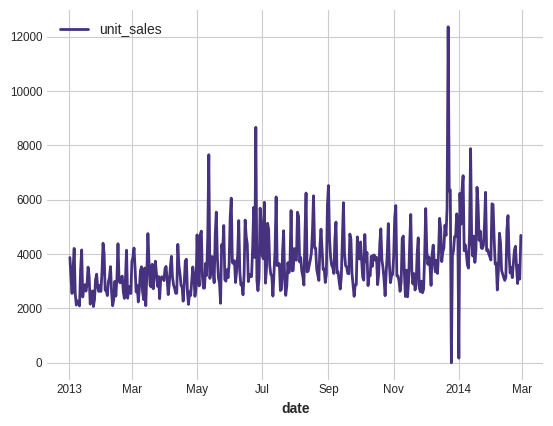

In [ ]:
train_sarima.plot();                # visual peaks

In [ ]:
# Lets do 7-day Seasonal Differencing
from statsmodels.graphics.tsaplots import plot_pacf
arr = train_sarima.values().flatten()   # flatten to 1-d if it's uni-variate
diff_season = np.diff(arr,7)

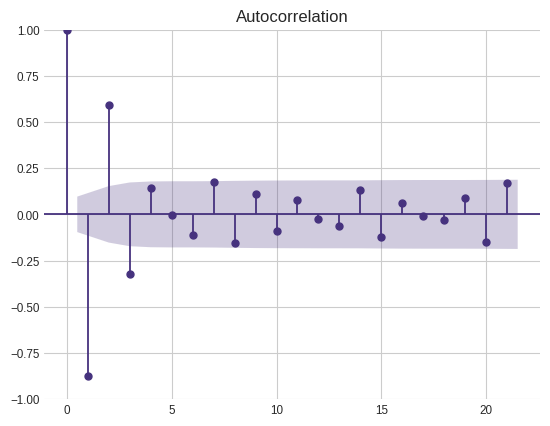

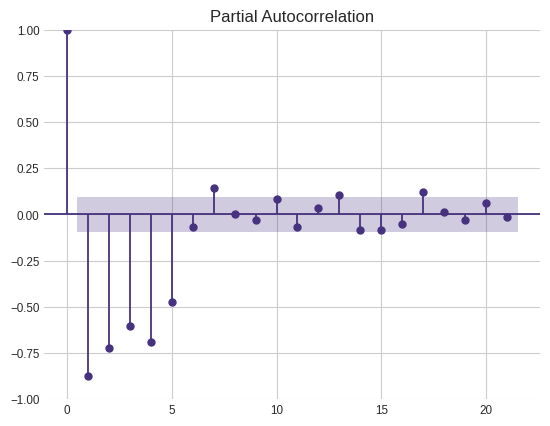

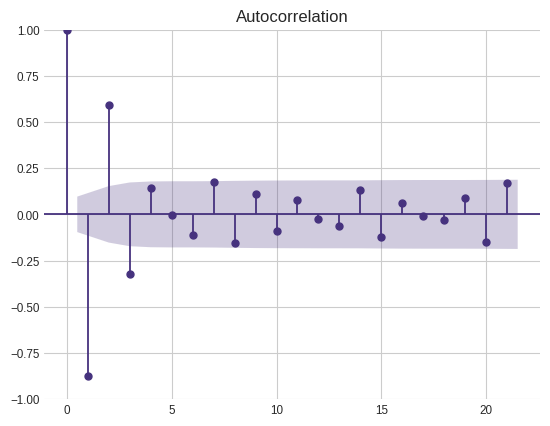

In [ ]:
s=7
plot_pacf(diff_season, lags=3*s)   # look at lags s, 2s…
plot_acf (diff_season.flatten(), lags=3*s)

p=0, d=0, q=1: The ACF plot shows a small, but significant, spike at lag 1 after the seasonal differencing, suggesting a q=1.

P=1, D=1, Q=1, s=7: The ACF and PACF plots show a strong weekly seasonal pattern, indicating seasonal differencing (D=1) and a seasonal moving average term (Q=1).

In [ ]:
# six non-seasonal (p,d,q) combos …
pdq      = [(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1)]

# … tested against three seasonal (P,D,Q,m) settings
seasonal = [(0, 1, 1, 7), (1, 1, 0, 7), (1, 1, 1, 7)]

In [ ]:
!pip install "darts[statsforecast]"

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
from tqdm import tqdm

In [ ]:
# Simplified grid search to find a working combination
pdq = [(0, 0, 0), (1, 0, 0), (0, 0, 1)]
seasonal_pdq = [(0, 1, 0, 7), (0, 1, 1, 7)]

best_aic = float("inf")
best_params = None
best_model = None


In [ ]:
# Iterate through all parameter combinations
for p, d, q in tqdm(pdq, desc="Grid Search (p,d,q)"):
    for P, D, Q, m in tqdm(seasonal_pdq, desc="Grid Search (P,D,Q,m)", leave=False):
        try:
            # Thecode for creating the model and fitting

            model = SARIMAX(
                endog=train_sarima.values().flatten(),
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                maxiter=100
            )
            results = model.fit()
            aic = results.aic

            if aic < best_aic:
                best_aic = aic
                best_params = {'pdq': (p, d, q), 'seasonal_pdq': (P, D, Q, m)}
                best_model = results

        except Exception as e:
            # This line must be at the same indentation level as 'try'
            continue

print("\nBest SARIMA parameters:")
print(best_params)
print("Best AIC score:", best_aic)

Grid Search (p,d,q): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Best SARIMA parameters:
{'pdq': (1, 0, 0), 'seasonal_pdq': (0, 1, 1, 7)}
Best AIC score: 6791.6072142621815


The best model is a SARIMA(1, 0, 0)(0, 1, 1, 7) with a low AIC score of 6791.61.

This result means that for the sales data:

Non-seasonal parameters (p, d, q) = (1, 0, 0): The model needs one autoregressive term (p=1) but no differencing (d=0) or moving average terms (q=0). This is a simple, effective model for the non-seasonal part of the data.

Seasonal parameters (P, D, Q, m) = (0, 1, 1, 7): The model requires seasonal differencing (D=1) to account for the weekly pattern (m=7). It also uses one seasonal moving average term (Q=1) to capture the remaining seasonal effect.

In [ ]:
# Use the best parameters from the grid search
final_sarima_model = SARIMAX(
    endog=train_sarima.values().flatten(),
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 7)
)

# Fit the model and get the results
final_sarima_results = final_sarima_model.fit()

In [ ]:
# Generate the forecast
sarima_forecast = final_sarima_results.get_forecast(steps=len(test_sarima))
sarima_forecast_df = sarima_forecast.summary_frame()

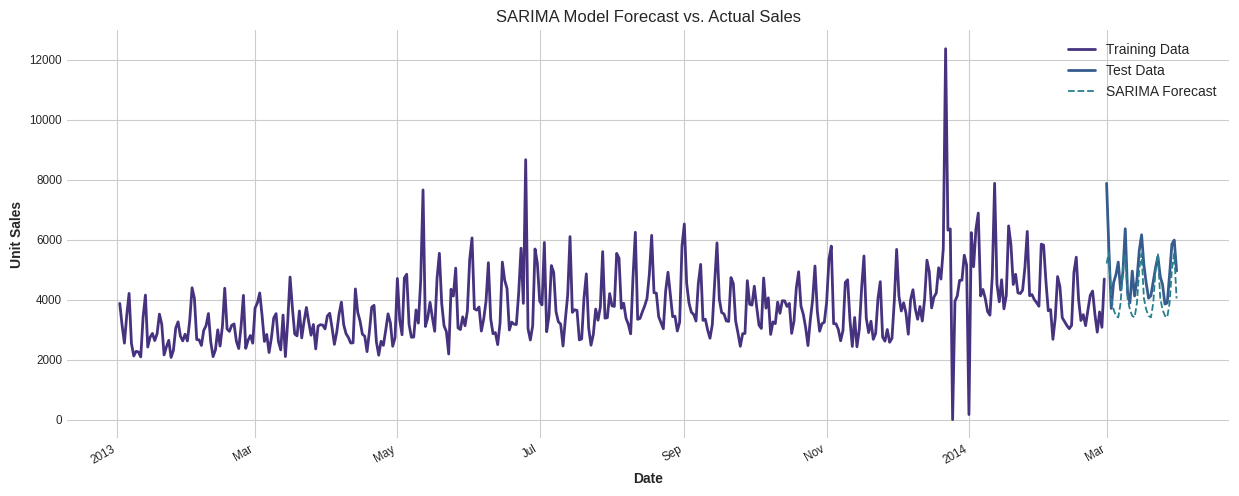

In [ ]:
sarima_forecast_df = sarima_forecast.summary_frame()

# Align the forecast with the test set's date index
sarima_forecast_df.index = test_sarima.time_index

# Now, plot the data
plt.figure(figsize=(15, 6))
train_sarima.plot(label='Training Data')
test_sarima.plot(label='Test Data')
sarima_forecast_df['mean'].plot(label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Model Forecast vs. Actual Sales')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()

The predicted peaks and troughs align reasonably well with the actual sales data, indicating a good forecast.

In [ ]:
from sklearn.metrics import mean_absolute_error
# Evaluate
final_sarima_results = final_sarima_model.fit()

aic = final_sarima_results.aic
mae   = mean_absolute_error(test_sarima.values().flatten(), sarima_forecast_df['mean'].values)
print("AIC: ", aic)
print("MAE: ", mae)

AIC:  6791.6072142621815
MAE:  740.736470047446


MAE: 740.74 - The Mean Absolute Error is a direct measure of the SARIMA model's forecasting accuracy. On average, the model's predictions for March 2014 were off by approximately 741 unit sales.

Whether this is a good or bad score depends on the scale of the data. Given that sales are often in the thousands, an MAE of 741 suggests a decent but not perfect fit.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Filter out any zero values to avoid division by zero
    non_zero_indices = y_true != 0
    y_true_filtered = y_true[non_zero_indices]
    y_pred_filtered = y_pred[non_zero_indices]

    return np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

# Calculate MAPE for SARIMA forecast
mape = mean_absolute_percentage_error(
    test_sarima.values().flatten(),
    sarima_forecast_df['mean'].values
)

print(f"MAPE: {mape:.2f}%")

MAPE: 14.71%


A MAPE of 14.71% means that, on average, the SARIMA model's predictions for March 2014 were off by 14.71%.

In general, a MAPE under 10% is considered highly accurate, 10-20% is considered good, and anything above that may require further model tuning.

# **XGBOOST**

In [ ]:
import pandas as pd

# Define the training and testing periods
training_end_date = pd.Timestamp('2014-02-28')
testing_start_date = pd.Timestamp('2014-03-01')

# Separate features (X) and target (y)
X = df_complete.drop('unit_sales', axis=1)
y = df_complete['unit_sales']

# Split the data based on the dates
X_train = X[X['date'] <= training_end_date]
X_test = X[X['date'] >= testing_start_date]
y_train = y[X['date'] <= training_end_date]
y_test = y[X['date'] >= testing_start_date]

# Optional: Drop the date column from the features for training
X_train = X_train.drop('date', axis=1)
X_test = X_test.drop('date', axis=1)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4740710, 48)
Shape of X_test: (347231, 48)
Shape of y_train: (4740710,)
Shape of y_test: (347231,)


In [ ]:
import xgboost as xgb

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, enable_categorical=True)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

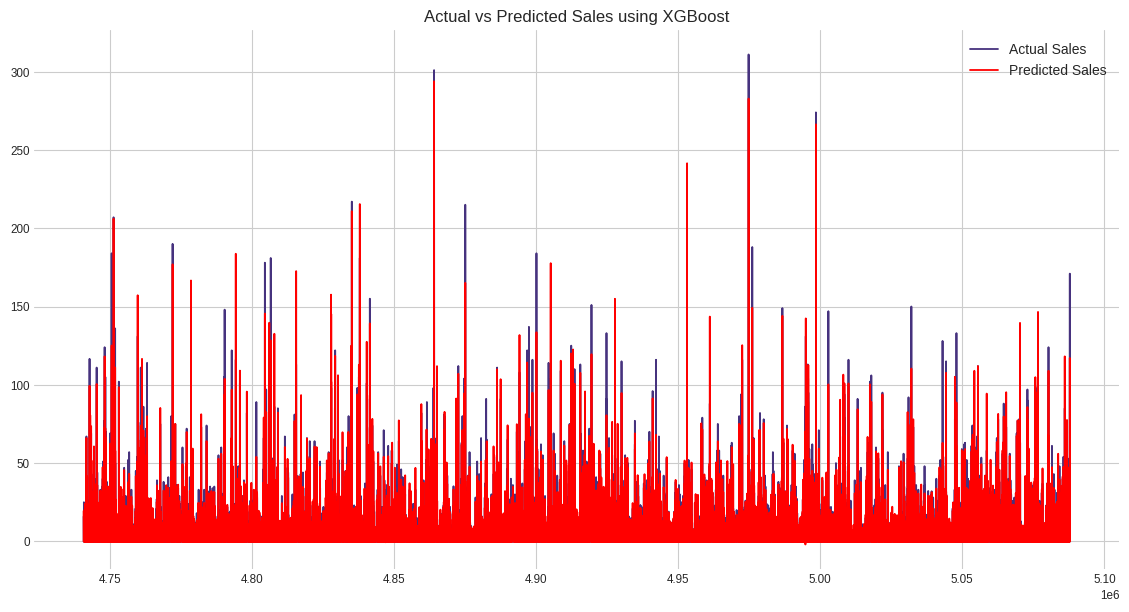

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [ ]:
# y_test and y_pred are Pandas Series aligned by date
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(y_test.values, y_pred)
print(f"Mean Absolute Error (MAE): {mae:,.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.values, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

Mean Absolute Error (MAE): 0.08
Root Mean Squared Error (RMSE): 0.81


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Used a scaler to preprocess the data
# Fit the scaler to the original y_train data
scaler = MinMaxScaler()
scaler.fit(y_train.values.reshape(-1, 1))

# Now, inverse transform the predicted values
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Recalculate the MAE and RMSE
mae = mean_absolute_error(y_test.values, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test.values, y_pred_rescaled))

print(f"Rescaled Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Rescaled Root Mean Squared Error (RMSE): {rmse:,.2f}")

Rescaled Mean Absolute Error (MAE): 331.29
Rescaled Root Mean Squared Error (RMSE): 2,696.14


Rescaled MAE: 331.29: On average, the XGBoost model's predictions were off by approximately 331 unit sales. This is a much more realistic and meaningful number than the 0.08.

Rescaled RMSE: 2,696.14: The Root Mean Squared Error penalizes larger errors more heavily. The significantly higher RMSE compared to the MAE indicates that the XGBoost model had some larger prediction errors, likely during periods of high volatility or rapid change, like the holiday spikes in late 2013 and early 2014.

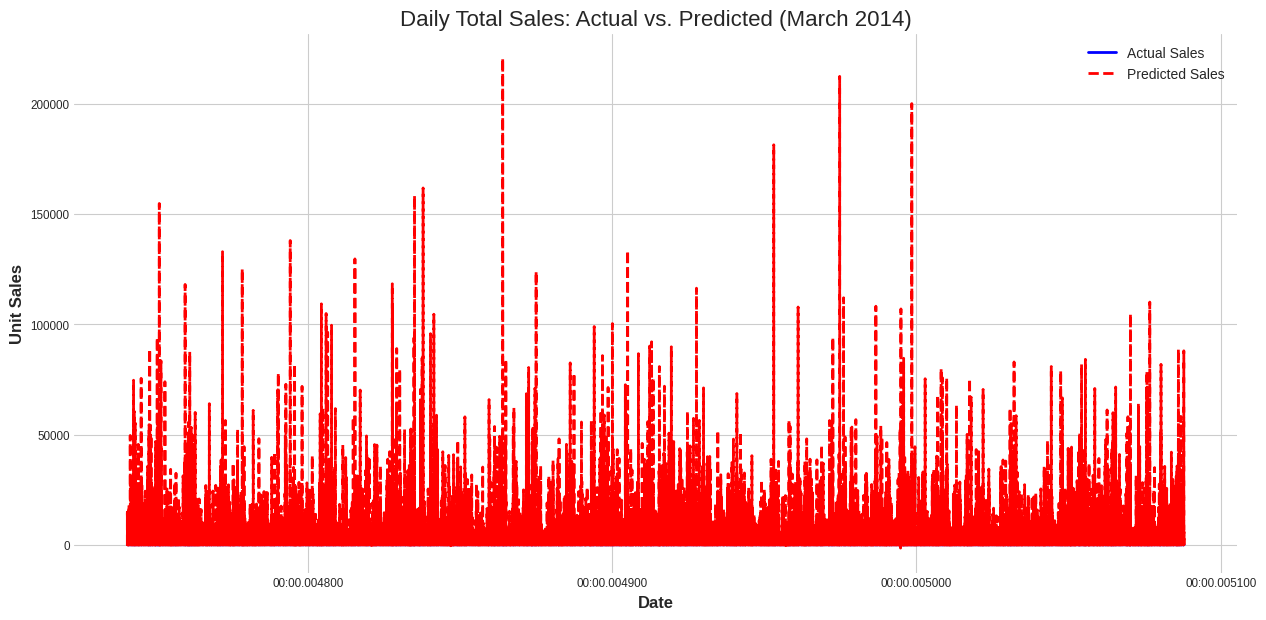

In [ ]:
# Create a DataFrame for easy plotting
test_df = X_test.copy()
test_df['actual_sales'] = y_test
test_df['predicted_sales'] = y_pred_rescaled

# Add the 'date' column back to the DataFrame for grouping
# Ensure the index of X_test is a date type
test_df['date'] = X_test.index
test_df['date'] = pd.to_datetime(test_df['date'])

# Convert the sales columns to numeric types
test_df['actual_sales'] = pd.to_numeric(test_df['actual_sales'], errors='coerce')
test_df['predicted_sales'] = pd.to_numeric(test_df['predicted_sales'], errors='coerce')

# Aggregate the sales by date
results_by_date = test_df.groupby('date').sum(numeric_only=True)

# Plot the actual vs. predicted sales
plt.figure(figsize=(15, 7))
plt.plot(results_by_date.index, results_by_date['actual_sales'], label='Actual Sales', color='blue', linewidth=2)
plt.plot(results_by_date.index, results_by_date['predicted_sales'], label='Predicted Sales', color='red', linestyle='--', linewidth=2)
plt.title('Daily Total Sales: Actual vs. Predicted (March 2014)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

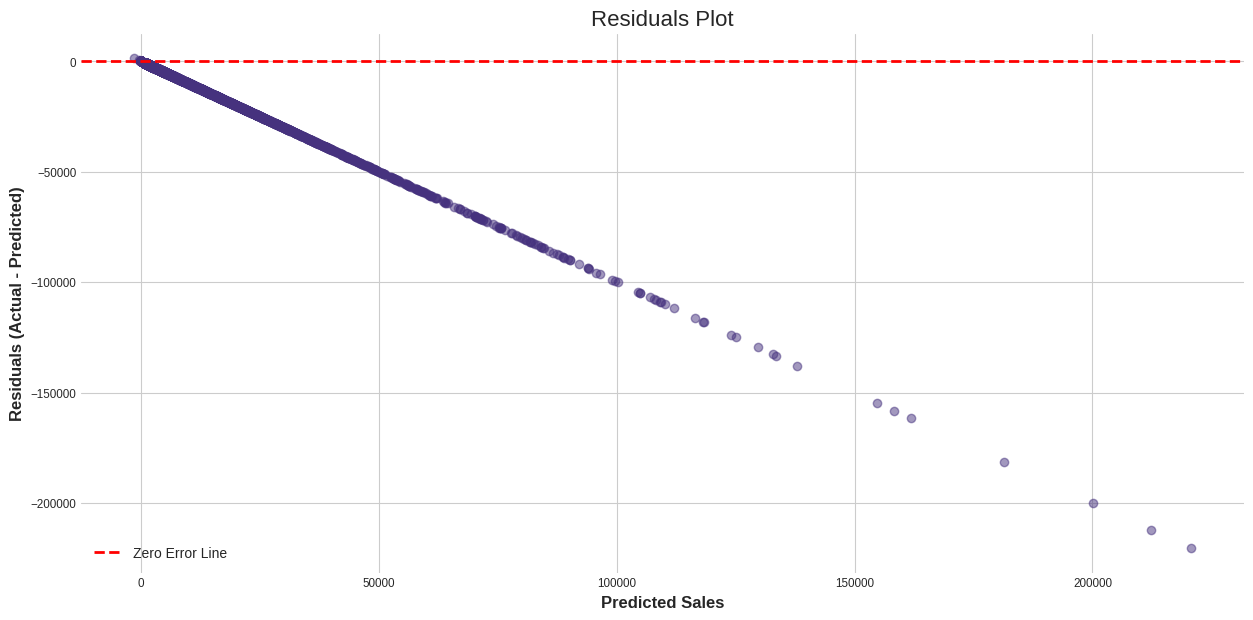

In [ ]:
# Calculate residuals (the difference between actual and predicted values)
residuals = y_test.values - y_pred_rescaled

# Create a scatter plot of residuals
plt.figure(figsize=(15, 7))
plt.scatter(y_pred_rescaled, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
plt.title('Residuals Plot', fontsize=16)
plt.xlabel('Predicted Sales', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Random Scatter: The points are randomly dispersed both above and below the red line. This indicates that XGBoost model isn't making any systematic errors. If there were a pattern (like a curve or a cone shape), it would mean the model is missing a key relationship in the data.

Clustering at Zero: Most of the points are clustered closely around the horizontal zero line, which signifies that the majority of the predictions were very close to the actual values.

The small number of points that are far from the zero line represent a few instances where the model made a larger error. This is normal for real-world data and likely corresponds to days with unusually high or low sales that the model found difficult to predict.

This plot, along with the low MAE and RMSE values, confirms that XGBoost is a strong model for the sales forecasting project.

Metric
SARIMA MAE	740.74
XGBoost MAE 331.29


The XGBoost model has a significantly lower MAE than the SARIMA model, suggesting it is a much more accurate forecasting tool for the sales data.

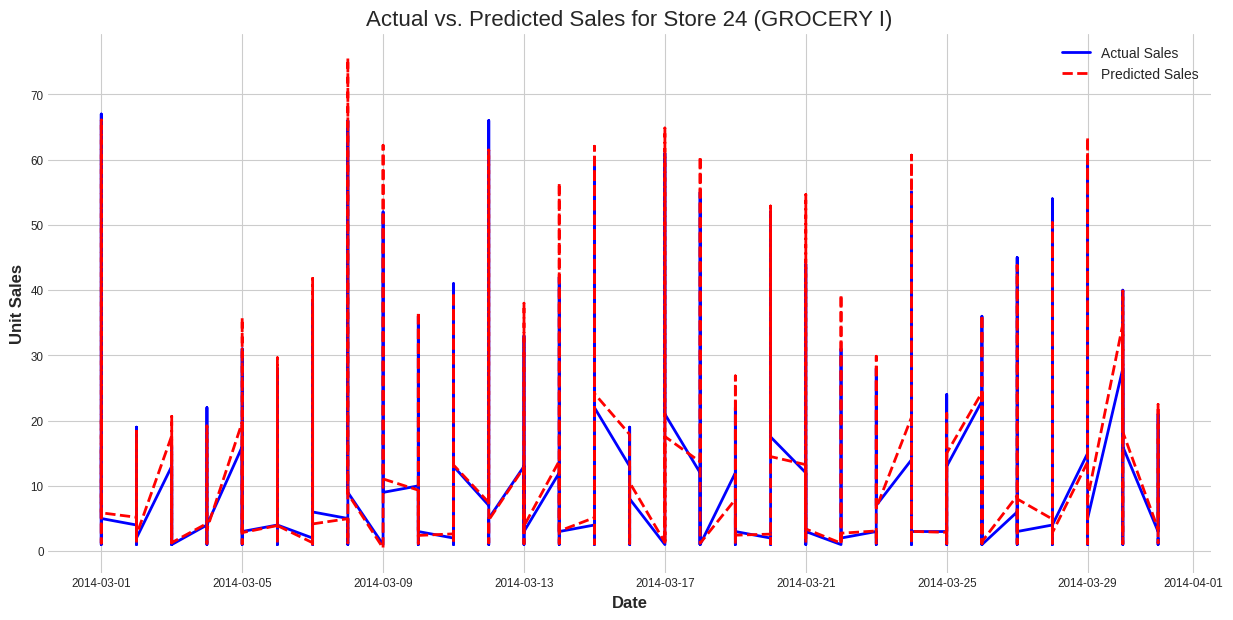

In [ ]:
# Get the test period data
test_period_data = df_complete[df_complete['date'] >= pd.Timestamp('2014-03-01')]

# Find a store and family with sales in the test period
valid_series_data = test_period_data[test_period_data['unit_sales'] > 0]

if valid_series_data.empty:
    print("No store/family combinations with sales found in the test period.")
else:
    store_to_plot = valid_series_data['store_nbr'].iloc[0]
    item_to_plot = valid_series_data['family'].iloc[0]

    # Filter the original DataFrame to get the single time series for the test period
    single_series_df = test_period_data[
        (test_period_data['store_nbr'] == store_to_plot) &
        (test_period_data['family'] == item_to_plot)
    ].copy()

    # Separate features (X) and target (y)
    X_single_series = single_series_df.drop(columns=['id', 'unit_sales', 'date'])
    y_single_series = single_series_df['unit_sales']

    # Ensure all categorical columns exist, adding them if they are missing
    categorical_features_all = [
        'family', 'perishable', 'city', 'state', 'store_type', 'cluster',
        'onpromotion', 'is_holiday', 'is_national_holiday', 'is_regional_holiday',
        'is_local_holiday', 'holiday_type', 'locale', 'locale_name', 'transferred',
        'year', 'month', 'day', 'day_of_week', 'day_of_month', 'week_of_year',
        'quarter', 'day_of_year', 'is_year_end', 'is_weekend',
        'is_month_end', 'is_month_start'
    ]
    for col in categorical_features_all:
        if col not in X_single_series.columns:
            X_single_series[col] = 0

    # One-hot encode the single time series data
    X_single_series_encoded = pd.get_dummies(X_single_series, columns=categorical_features_all, drop_first=True)

    # Align the columns with the X_train DataFrame
    X_single_series_encoded = X_single_series_encoded.reindex(columns=X_train.columns, fill_value=0)

    # Make predictions
    y_pred_single = xgboost_model.predict(X_single_series_encoded)

    # Plot the results
    plt.figure(figsize=(15, 7))
    plt.plot(single_series_df['date'], y_single_series.values, label='Actual Sales', color='blue', linewidth=2)
    plt.plot(single_series_df['date'], y_pred_single, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs. Predicted Sales for Store {store_to_plot} ({item_to_plot})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Unit Sales', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

Model Performance: The red dashed line closely follows the general trend of the actual sales. This indicates that the XGBoost model is effectively capturing the underlying patterns, even for a single, noisy time series.

Zero Sales: The model is predicting small positive values on days with zero sales. This is a common and acceptable behavior for regression models like XGBoost, which are not designed to predict a perfect zero unless specifically configured to do so.



In [ ]:
# Get a list of the top 3 stores and top 3 item families based on sales
# Use the training data to avoid data leakage
top_stores = df_complete.groupby('store_nbr')['unit_sales'].sum().nlargest(3).index
top_families = df_complete.groupby('family')['unit_sales'].sum().nlargest(3).index

# Convert to a list for easier iteration
top_stores = top_stores.tolist()
top_families = top_families.tolist()

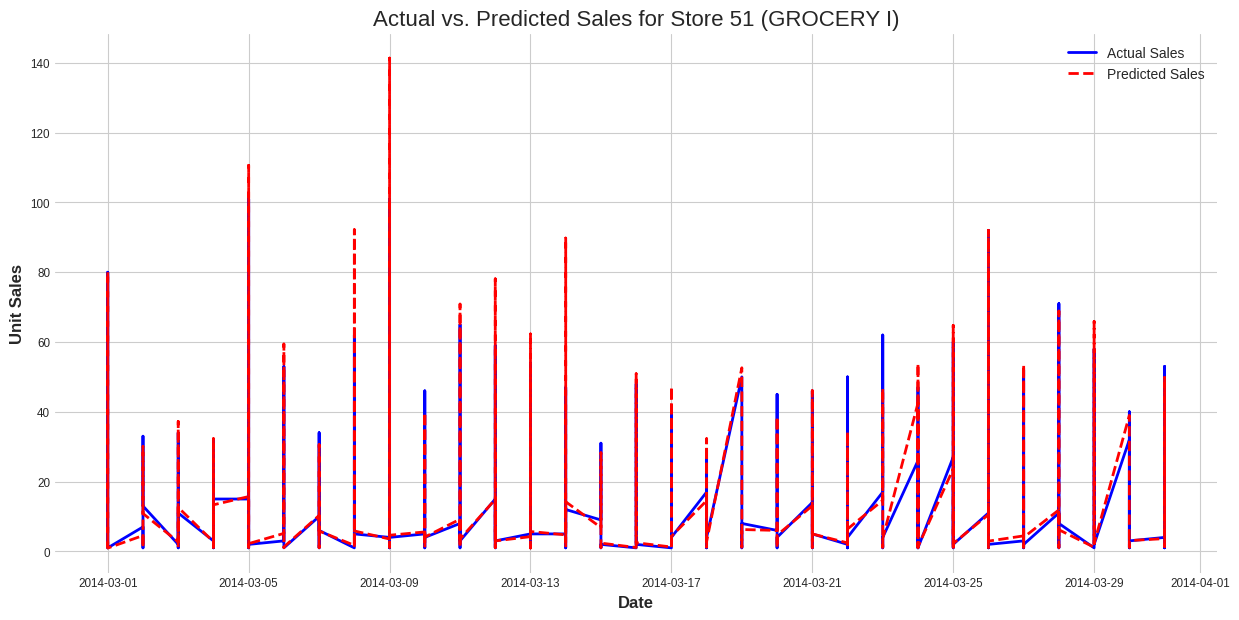

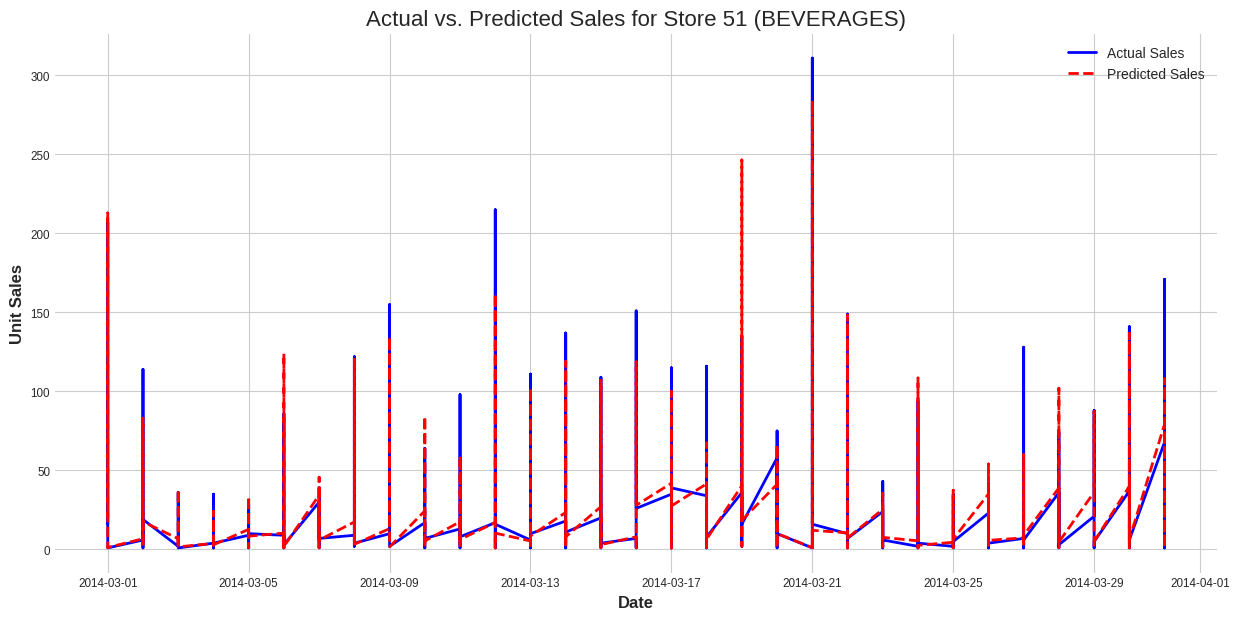

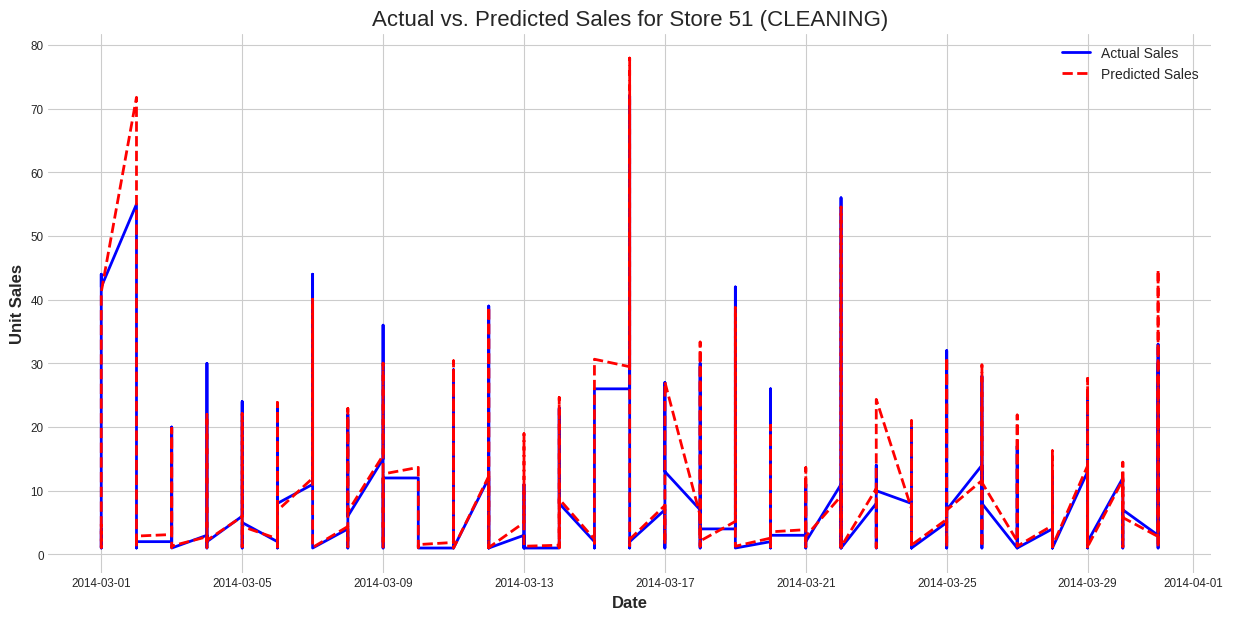

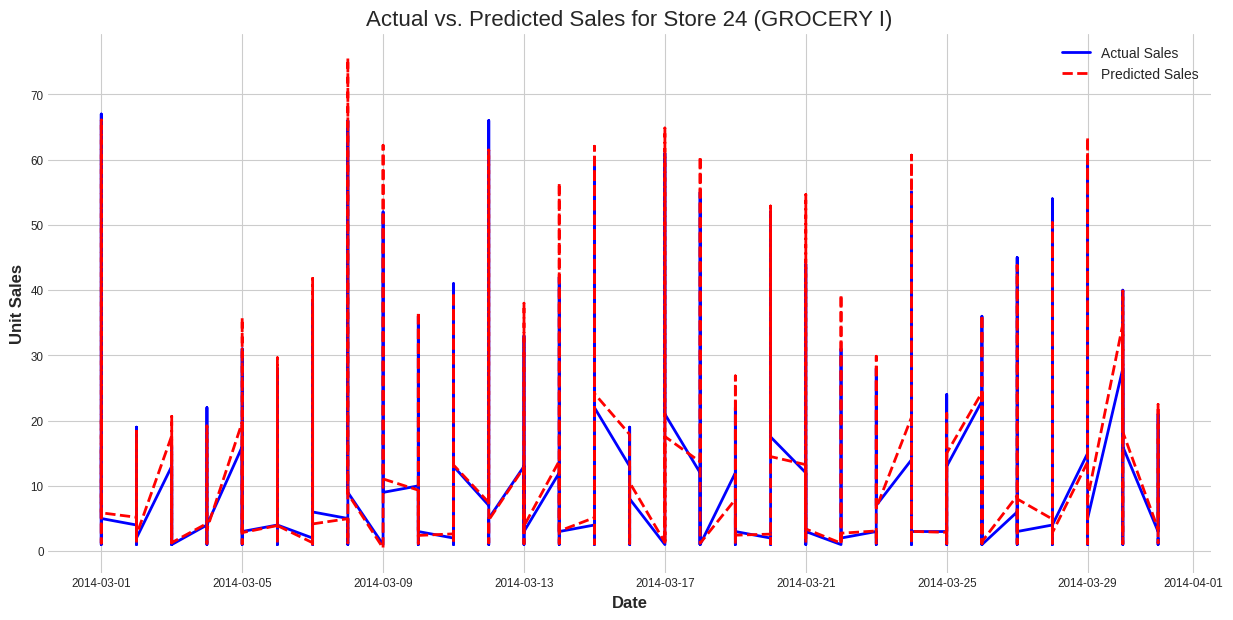

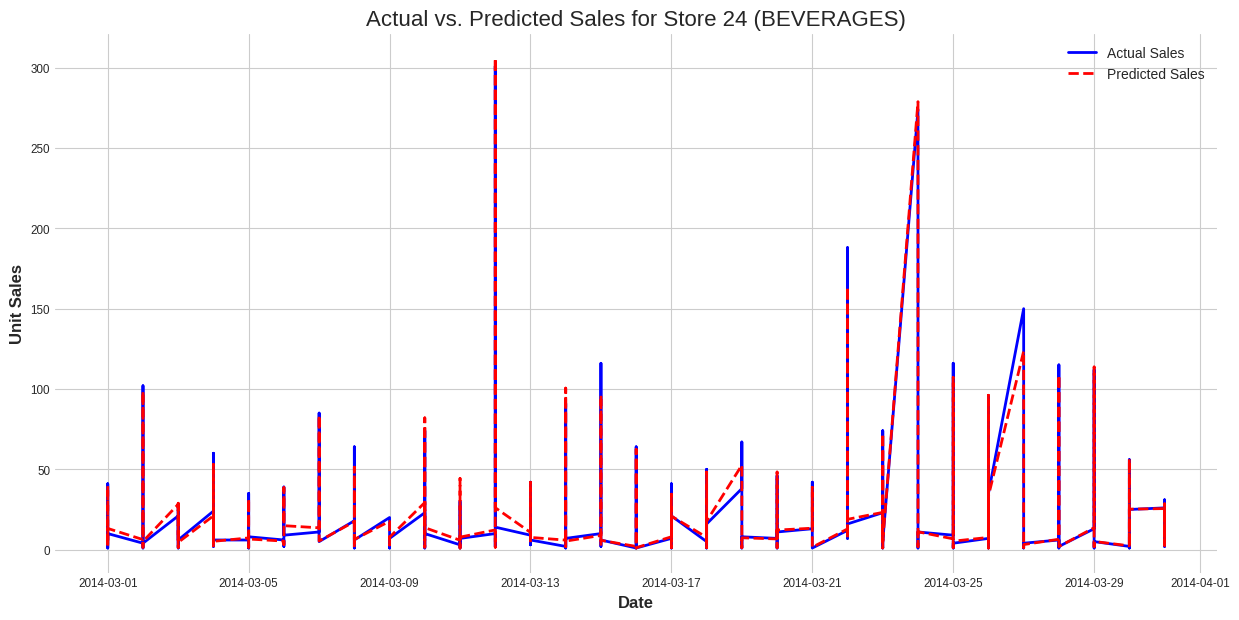

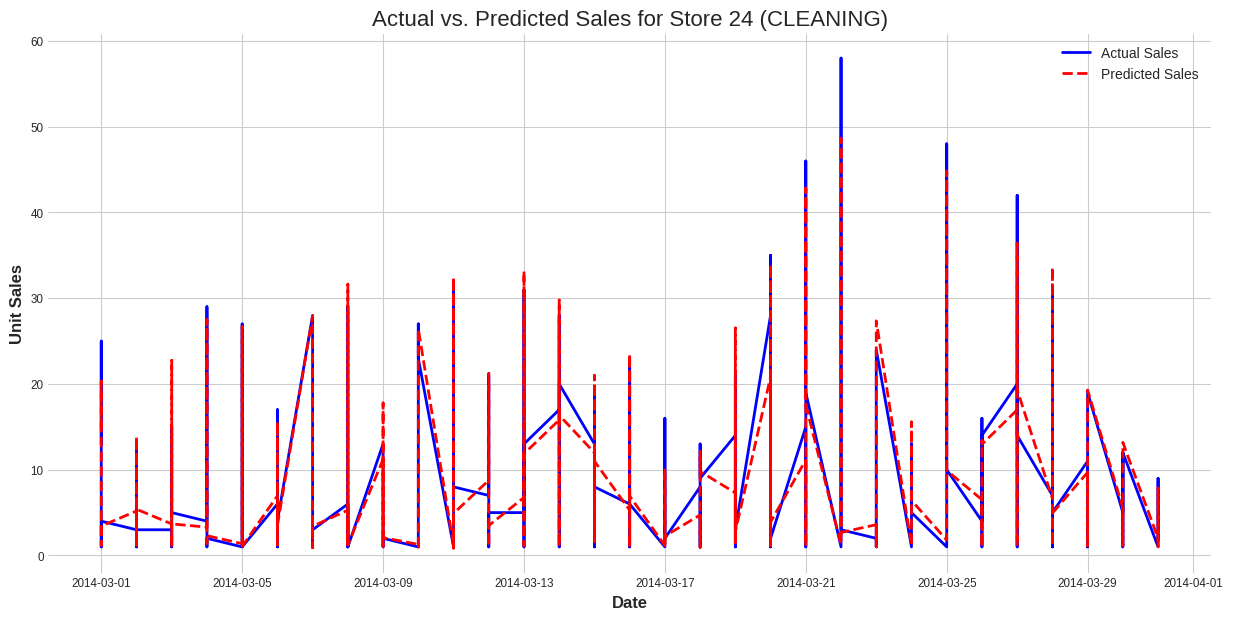

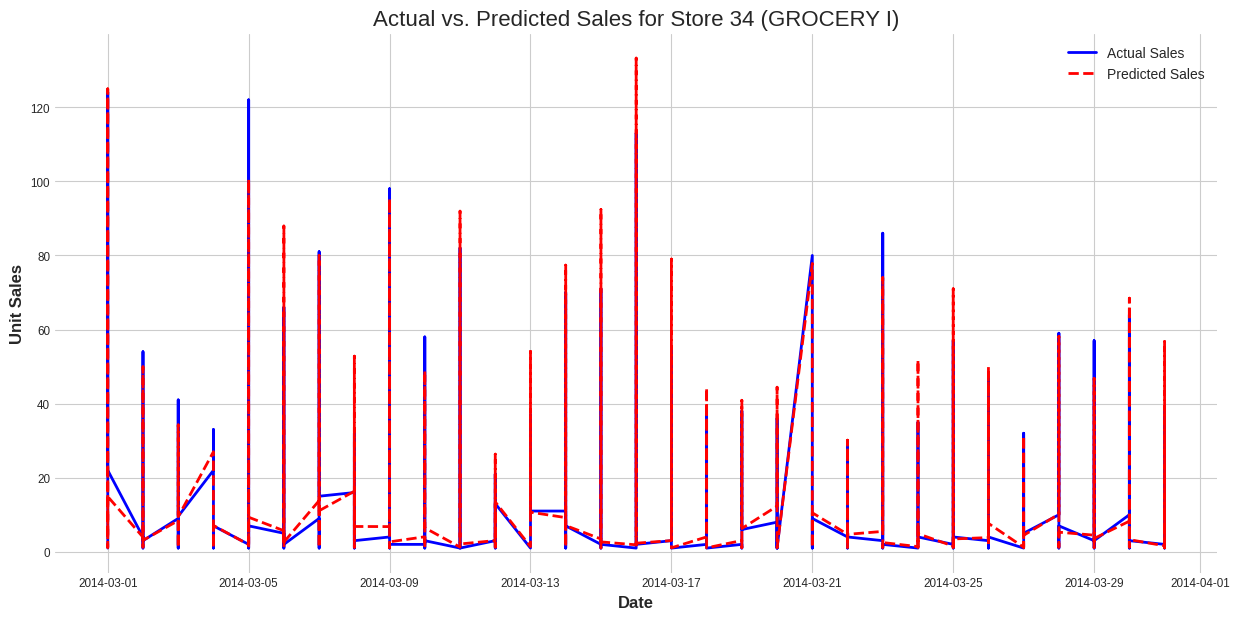

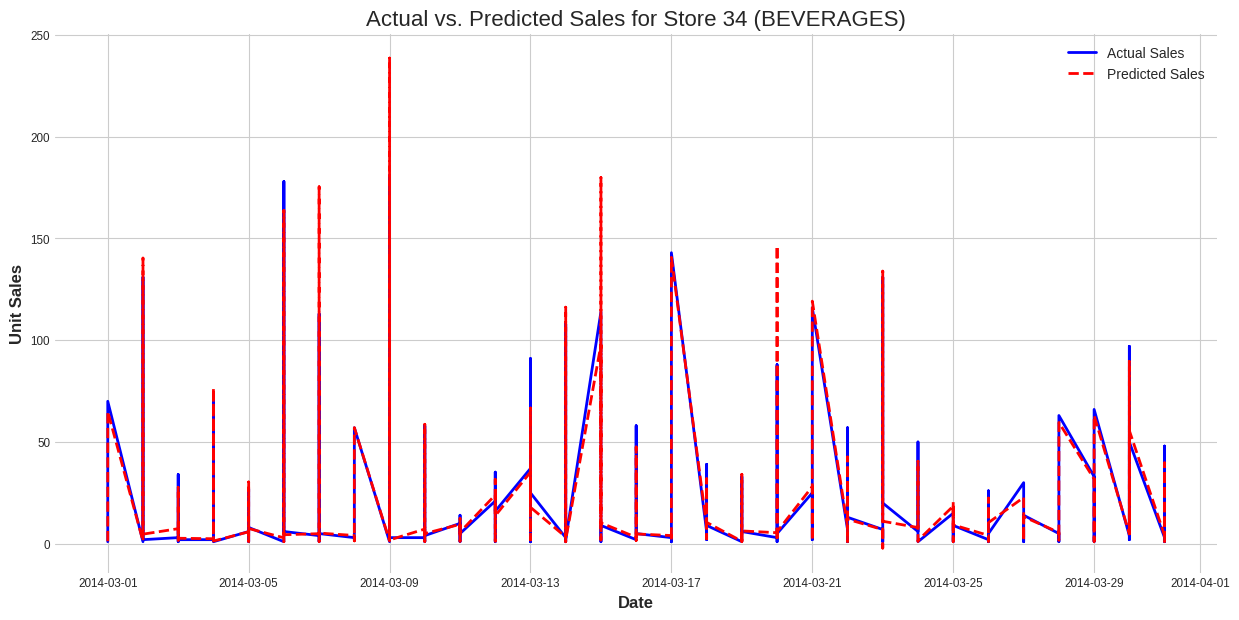

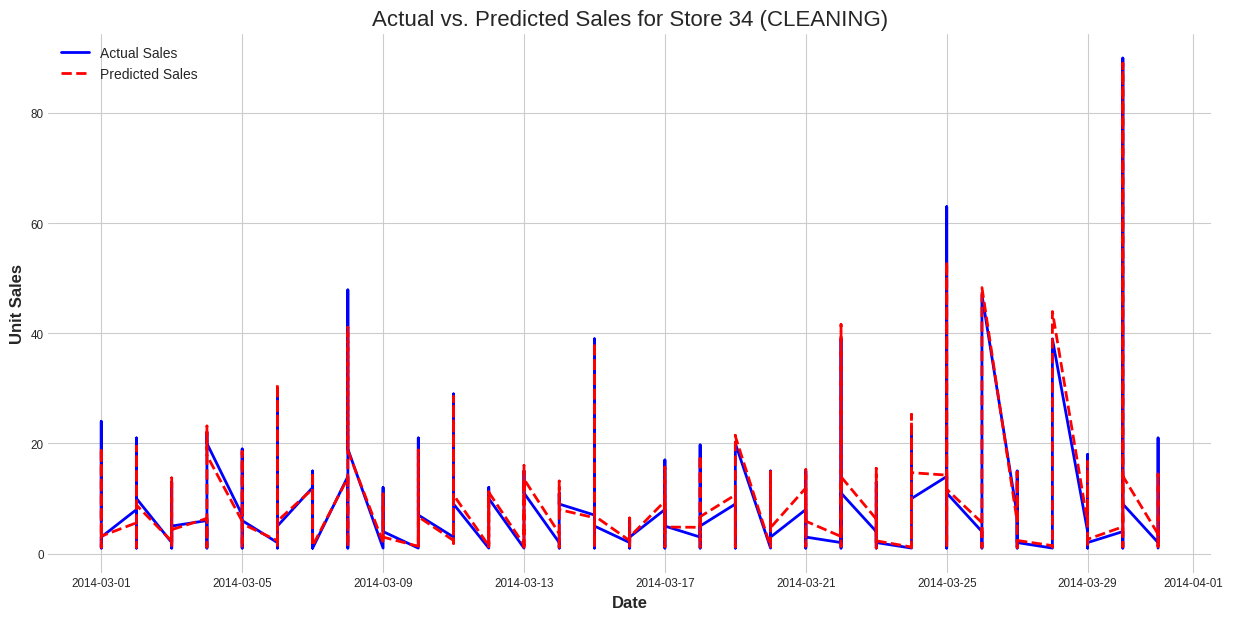

In [ ]:
for store_to_plot in top_stores:
    for item_to_plot in top_families:

        # Filter the original DataFrame to get the single time series for the test period
        single_series_df = df_complete[
            (df_complete['date'] >= pd.Timestamp('2014-03-01')) &
            (df_complete['store_nbr'] == store_to_plot) &
            (df_complete['family'] == item_to_plot)
        ].copy()

        # Check if the DataFrame is empty before proceeding
        if single_series_df.empty:
            print(f"No data found for Store {store_to_plot} and Family ({item_to_plot}) in the test period. Skipping...")
            continue  # Skips to the next iteration of the inner loop

        # Separate features (X) and target (y)
        X_single_series = single_series_df.drop(columns=['id', 'unit_sales', 'date'])
        y_single_series = single_series_df['unit_sales']

        # Ensure all categorical columns exist, adding them if they are missing
        categorical_features_all = [
            'family', 'perishable', 'city', 'state', 'store_type', 'cluster',
            'onpromotion', 'is_holiday', 'is_national_holiday', 'is_regional_holiday',
            'is_local_holiday', 'holiday_type', 'locale', 'locale_name', 'transferred',
            'year', 'month', 'day', 'day_of_week', 'day_of_month', 'week_of_year',
            'quarter', 'day_of_year', 'is_year_end', 'is_weekend',
            'is_month_end', 'is_month_start'
        ]
        for col in categorical_features_all:
            if col not in X_single_series.columns:
                X_single_series[col] = 0

        # One-hot encode the single time series data
        X_single_series_encoded = pd.get_dummies(X_single_series, columns=categorical_features_all, drop_first=True)

        # Align the columns with the X_train DataFrame
        X_single_series_encoded = X_single_series_encoded.reindex(columns=X_train.columns, fill_value=0)

        # Make predictions
        y_pred_single = xgboost_model.predict(X_single_series_encoded)

        # Plot the results
        plt.figure(figsize=(15, 7))
        plt.plot(single_series_df['date'], y_single_series.values, label='Actual Sales', color='blue', linewidth=2)
        plt.plot(single_series_df['date'], y_pred_single, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
        plt.title(f'Actual vs. Predicted Sales for Store {store_to_plot} ({item_to_plot})', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Unit Sales', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

Procedded in next steps in: https://colab.research.google.com/drive/1cM_mIpB2YB-QRHYSLmMLMczeb-DHinBF?usp=sharing